## Part 1: Setup & Preprocessing

In [75]:
# Standard Libraries
import pandas as pd
import numpy as np
import json

# Data Preprocessing & NLP
import nltk
import re
import string
import gensim
from textblob import Word

import xgboost as xgb
from xgboost import XGBClassifier

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
# nltk.download()
nltk.download('wordnet')
nltk.download('stopwords')

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, VotingClassifier, AdaBoostClassifier, BaggingRegressor, GradientBoostingClassifier,BaggingClassifier
from sklearn.naive_bayes import GaussianNB

from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics.pairwise import linear_kernel

# Performance metrics
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, make_scorer, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics.pairwise import cosine_similarity

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
sns.set()
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package wordnet to /home/user/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /home/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
news_df = pd.read_csv('bbc-text.csv')

In [45]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   category  2225 non-null   object
 1   text      2225 non-null   object
dtypes: object(2)
memory usage: 34.9+ KB


In [46]:
news_df['category'].value_counts()

sport            511
business         510
politics         417
tech             401
entertainment    386
Name: category, dtype: int64

In [47]:
# Associate Category names with numerical index and save it in new column category_id
news_df['category_id'] = news_df['category'].factorize()[0]


In [48]:
# Create a new pandas dataframe "category_id_df", which only has unique Categories, also sorting this list in order of category_id values
category_id_df = news_df[['category', 'category_id']].drop_duplicates().sort_values('category_id')

In [49]:
# Create a dictionary ( python datastructure - like a lookup table) that 
# can easily convert category names into category_ids and vice-versa
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'category']].values)

In [50]:
id_to_category

{0: 'tech', 1: 'business', 2: 'sport', 3: 'entertainment', 4: 'politics'}

In [51]:
category_id_df

,category,category_id
0,tech,0
1,business,1
2,sport,2
4,entertainment,3
5,politics,4


## Part 2. Visualization

<AxesSubplot:xlabel='category'>

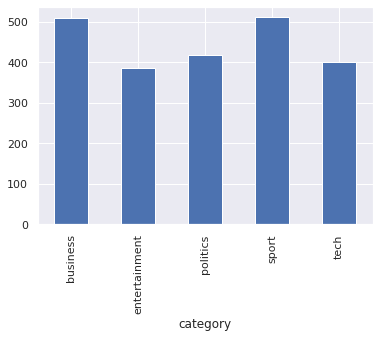

In [52]:
#Plot the distribution of news articles by category
news_df.groupby('category').category_id.count().plot.bar(ylim=0)

In [63]:
# Drop duplicate data
news_df.drop_duplicates(subset=['category', 'text'], inplace=True)

In [64]:
# Data Cleaning
def clean_text(text):
    # remove everything except alphabets
    text = re.sub("[^a-zA-Z]", " ", text)
    # remove whitespaces
    text = ' '.join(text.split())
    text = text.lower()
    
    return text

In [65]:
# creating clean text feature
news_df['clean_text'] = news_df['text'].apply(clean_text).str.replace('bn bn ', '')

# creating clean text feature
news_df['clean_text'] = news_df['text'].apply(clean_text).str.replace(' bn ', '')

In [66]:
def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * 55.0 / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)

def freq_words(x, terms = 30):
    all_words = ' '.join([text for text in x])
    all_words = all_words.split()
    
    freq_dist = nltk.FreqDist(all_words)
    words_df = pd.DataFrame({'word':list(freq_dist.keys()), 'count':list(freq_dist.values())})
    
    fig = plt.figure(figsize=(21,16))
    ax1 = fig.add_subplot(2,1,1)
    wordcloud = WordCloud(width=1000, height=300, background_color='black', 
                          max_words=1628, relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False).generate_from_frequencies(freq_dist)
    
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    
    # select top 20 most frequent word
    ax2 = fig.add_subplot(2,1,2)
    d = words_df.nlargest(columns="count", n = terms) 
    ax2 = sns.barplot(data=d, palette = sns.color_palette('BuGn_r'), x= "count", y = "word")
    ax2.set(ylabel= 'Word')
    plt.show()

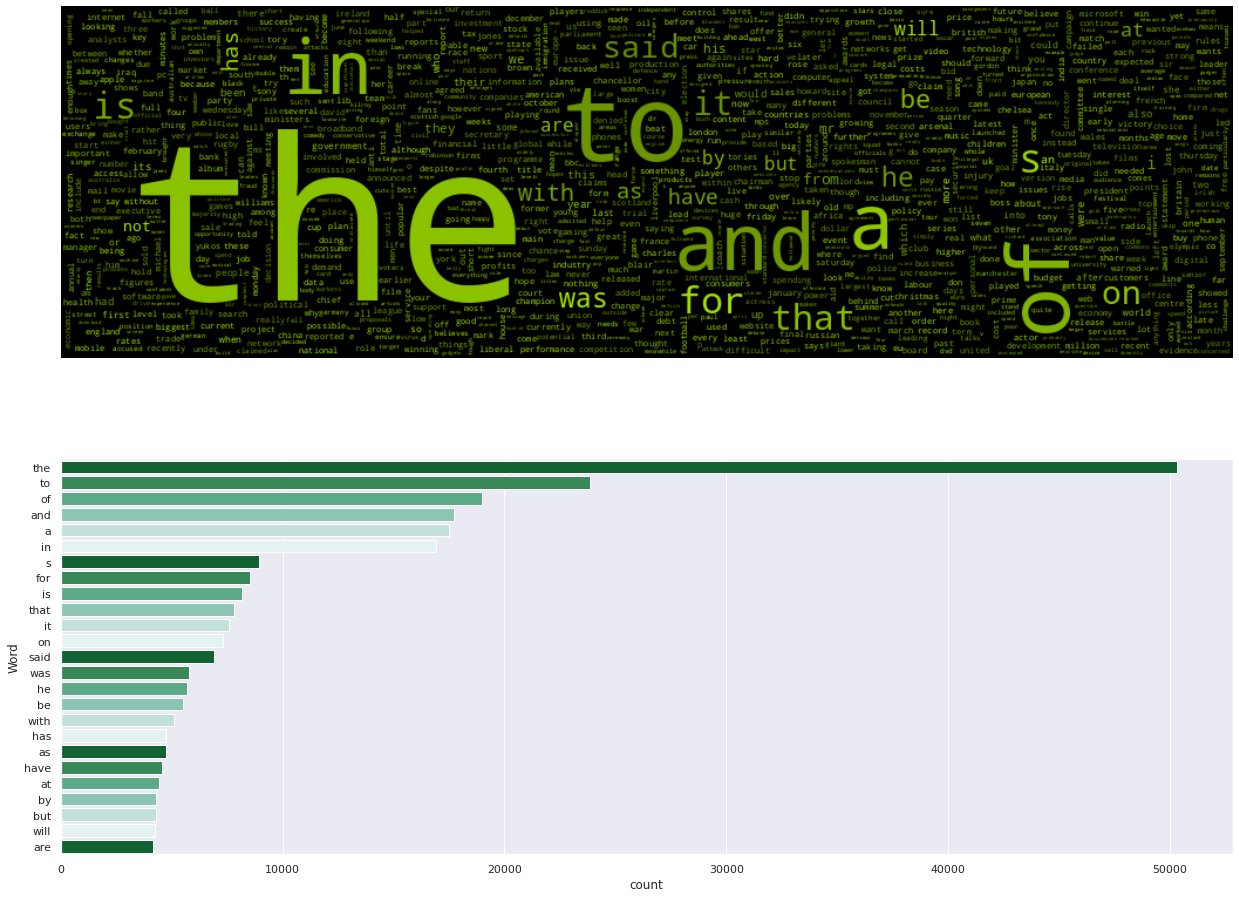

In [67]:
# plot 25 most frequent words including stop words
freq_words(news_df['clean_text'], 25)

In [68]:
# stopwords-to compare text data with and without stopwords

stop_words = set(stopwords.words('english'))

# function to remove stopwords
def remove_stopwords(text):
    no_stopword_text = [w for w in text.split() if not w in stop_words]
    return ' '.join(no_stopword_text)
  
news_df['clean_text'] = news_df['clean_text'].apply(lambda x: remove_stopwords(x))

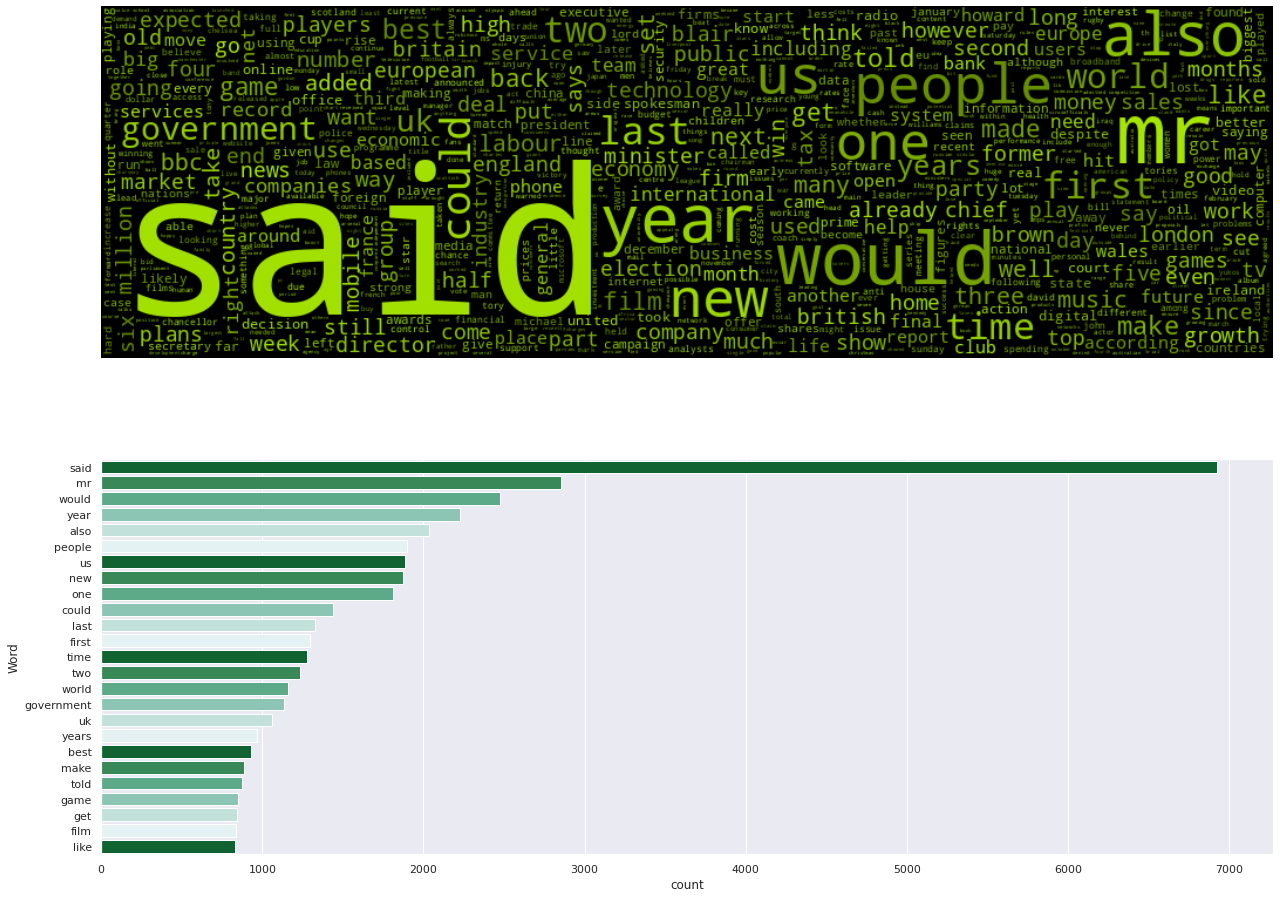

In [69]:
# plot 25 most frequent words without stopwords
freq_words(news_df['clean_text'], 25)

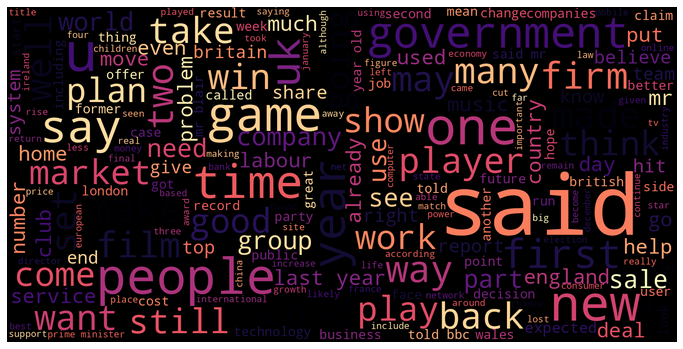

In [110]:
text = " ".join(review for review in news_df.clean_text)
wordcloud = WordCloud(width=1600, height=800,max_font_size=200, colormap='magma').generate(text)

plt.figure(figsize = (12, 10))
plt.imshow(wordcloud, interpolation='spline36')
plt.axis("off")
plt.show()

In [71]:
wordcloud.to_file("wordcloud.png")

In [72]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2126 non-null   object
 1   text         2126 non-null   object
 2   category_id  2126 non-null   int64 
 3   clean_text   2126 non-null   object
dtypes: int64(1), object(3)
memory usage: 83.0+ KB


## Part 3: Heading to Machine Learning

In [73]:
# Lemmatization process
'''
Words in the third person are changed to first person and verbs in past and future tenses are changed into the present by the 
lemmatization process. 
'''
lemmatizer = WordNetLemmatizer()

def tokenize_and_lemmatize(text):
    # tokenization to ensure that punctuation is caught as its own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    lem = [lemmatizer.lemmatize(t) for t in filtered_tokens]
    return lem

In [76]:
# Defining a Count Vectorizer object
count_vec = CountVectorizer(stop_words='english', max_features=10000)
# Defining a TF-IDF Vectorizer
tfidf_vec = TfidfVectorizer(stop_words='english', ngram_range=(1, 2), tokenizer=tokenize_and_lemmatize, max_features=10000, use_idf=True)

features = tfidf_vec.fit_transform(news_df.clean_text).toarray() # Remaps the words in the 2225 articles in the text column of 
                                                  # data frame into features (superset of words) with an importance assigned 
                                                  # based on each words frequency in the document and across documents

labels = news_df.category_id                           # represents the category of each of the 2225 articles


In [77]:
#Get a feel of the features identified by tfidf
features.shape # How many features are there ? 

(2126, 10000)

In [78]:
# Remember the dictionary created to map category names to a number ? 
category_to_id.items()

dict_items([('tech', 0), ('business', 1), ('sport', 2), ('entertainment', 3), ('politics', 4)])

In [79]:
# The sorted function Converts dictionary items into a (sorted) list. 
# In subsequent steps - We will use this list to iterate over the categories
sorted(category_to_id.items())

[('business', 1),
 ('entertainment', 3),
 ('politics', 4),
 ('sport', 2),
 ('tech', 0)]

In [80]:
news_df.to_csv('out_df.csv', index=False)

In [81]:
# Use chi-square analysis to find corelation between features (importantce of words) and labels(news category) 
from sklearn.feature_selection import chi2

N = 3  # We are going to look for top 3 categories

#For each category, find words that are highly corelated to it
for category, category_id in sorted(category_to_id.items()):
    features_chi2 = chi2(features, labels == category_id)                   # Do chi2 analyses of all items in this category
    indices = np.argsort(features_chi2[0])                                  # Sorts the indices of features_chi2[0] - the chi-squared stats of each feature
    feature_names = np.array(tfidf_vec.get_feature_names())[indices]            # Converts indices to feature names ( in increasing order of chi-squared stat values)
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]         # List of single word features ( in increasing order of chi-squared stat values)
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]          # List for two-word features ( in increasing order of chi-squared stat values)
    print("# '{}':".format(category))
    print("  . Most correlated unigrams:\n       . {}".format('\n       . '.join(unigrams[-N:]))) # Print 3 unigrams with highest Chi squared stat
    print("  . Most correlated bigrams:\n       . {}".format('\n       . '.join(bigrams[-N:]))) # Print 3 bigrams with highest Chi squared stat

# 'business':
  . Most correlated unigrams:
       . growth
       . oil
       . bank
  . Most correlated bigrams:
       . oil price
       . economic growth
       . stock market
# 'entertainment':
  . Most correlated unigrams:
       . oscar
       . award
       . film
  . Most correlated bigrams:
       . los angeles
       . film festival
       . box office
# 'politics':
  . Most correlated unigrams:
       . blair
       . election
       . labour
  . Most correlated bigrams:
       . prime minister
       . mr brown
       . mr blair
# 'sport':
  . Most correlated unigrams:
       . champion
       . cup
       . match
  . Most correlated bigrams:
       . champion league
       . australian open
       . grand slam
# 'tech':
  . Most correlated unigrams:
       . technology
       . user
       . mobile
  . Most correlated bigrams:
       . high definition
       . mobile phone
       . e mail


In [82]:
features_chi2

(array([1.07280884e-01, 1.03328741e-01, 9.00147526e-02, ...,
        5.73756215e-05, 9.41695821e-02, 1.34694294e-01]),
 array([0.7432613 , 0.747871  , 0.7641584 , ..., 0.99395635, 0.75894185,
        0.71361364]))

In [83]:
news_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2126 entries, 0 to 2224
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   category     2126 non-null   object
 1   text         2126 non-null   object
 2   category_id  2126 non-null   int64 
 3   clean_text   2126 non-null   object
dtypes: int64(1), object(3)
memory usage: 83.0+ KB


In [84]:
X = news_df.loc[:,'clean_text']
y = news_df.loc[:,'category_id']

In [85]:
# Basic validation: splitting the data 80-20-20 train/test
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(X, y, news_df.index, test_size=0.2, random_state=55)
#X_train, X_cv, y_train, y_cv = train_test_split(X,y,test_size=.25, random_state=10)


In [86]:
# Tf-Idf transformation 
xtrain_tfidf = tfidf_vec.fit_transform(X_train)
xtest_tfidf = tfidf_vec.transform(X_test)
#xcv_tfidf = tfidf_vec.fit_transform(X_cv)
xtrain_tfidf.shape

(1700, 10000)

In [87]:
# Count Vectorizer transformation
xtrain_cv = count_vec.fit_transform(X_train)
xtest_cv = count_vec.transform(X_test)
xtrain_cv.shape

(1700, 10000)

## Part 4: Model Training and Evaluation

In [88]:
#create list of model and accuracy dicts
perform_list = []

In [105]:
def run_model(model_name, est_c, est_pnlty):
    mdl=''
    if model_name == 'Logistic Regression':
        mdl = LogisticRegression()
    elif model_name == 'Random Forest':
        mdl = RandomForestClassifier(n_estimators=100)
    elif model_name == 'Multinomial Naive Bayes':
        mdl = MultinomialNB()
    elif model_name == 'Linear SVC':
        mdl = LinearSVC()
    elif model_name == 'Logistic Regression GridSearchCV':
        mdl = LogisticRegression(C=est_c, penalty=est_pnlty)        

    oneVsRest = OneVsRestClassifier(mdl)
    oneVsRest.fit(xtrain_tfidf, y_train)
    y_pred = oneVsRest.predict(xtest_tfidf)
    
    
    # Performance metrics
    accuracy = round(accuracy_score(y_test, y_pred) * 100, 2)
    # Get precision, recall, f1 scores
    precision, recall, f1score, support = score(y_test, y_pred, average='micro')

    print(f'Test Accuracy Score of Basic {model_name}: % {accuracy}')
    print(f'Precision : {precision}')
    print(f'Recall    : {recall}')
    print(f'F1-score   : {f1score}')

    # Add performance parameters to list
    perform_list.append(dict([
        ('Model', model_name),
        ('Test Accuracy', round(accuracy, 2)),
        ('Precision', round(precision, 2)),
        ('Recall', round(recall, 2)),
        ('F1', round(f1score, 2))
         ]))

In [106]:
run_model('Random Forest', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Random Forest: % 96.24
Precision : 0.9624413145539906
Recall    : 0.9624413145539906
F1-score   : 0.9624413145539906


In [107]:
run_model('Logistic Regression', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Logistic Regression: % 96.71
Precision : 0.9671361502347418
Recall    : 0.9671361502347418
F1-score   : 0.9671361502347418


In [108]:
run_model('Multinomial Naive Bayes', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Multinomial Naive Bayes: % 96.95
Precision : 0.9694835680751174
Recall    : 0.9694835680751174
F1-score   : 0.9694835680751174


In [109]:
run_model('Linear SVC', est_c=None, est_pnlty=None)

Test Accuracy Score of Basic Linear SVC: % 97.18
Precision : 0.971830985915493
Recall    : 0.971830985915493
F1-score   : 0.971830985915493


### Performance metrics of models

In [94]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,95.77,0.96,0.96,0.96
1,Logistic Regression,96.71,0.97,0.97,0.97
2,Multinomial Naive Bayes,96.95,0.97,0.97,0.97
3,Linear SVC,97.18,0.97,0.97,0.97


## Optimization 

### RandomForest GridCV

In [95]:
param = {'estimator__penalty':['l1', 'l2'], 'estimator__C':[0.001, 0.01, 1, 10]}

In [96]:
opt_mdl = LogisticRegression()
oneVsRest = OneVsRestClassifier(opt_mdl)
oneVsRest.get_params().keys()

dict_keys(['estimator__C', 'estimator__class_weight', 'estimator__dual', 'estimator__fit_intercept', 'estimator__intercept_scaling', 'estimator__l1_ratio', 'estimator__max_iter', 'estimator__multi_class', 'estimator__n_jobs', 'estimator__penalty', 'estimator__random_state', 'estimator__solver', 'estimator__tol', 'estimator__verbose', 'estimator__warm_start', 'estimator', 'n_jobs'])

In [97]:
# GridSearchCV
kf=KFold(n_splits=10, shuffle=True, random_state=55)
lr_grid = GridSearchCV(oneVsRest, param_grid = param, cv = kf, scoring='f1_micro', n_jobs=-1)
lr_grid.fit(xtrain_tfidf, y_train)
lr_grid.best_params_

{'estimator__C': 10, 'estimator__penalty': 'l2'}

In [44]:
run_model('Logistic Regression GridSearchCV',lr_grid.best_params_['estimator__C'],lr_grid.best_params_['estimator__penalty'])

Test Accuracy Score of Basic Logistic Regression GridSearchCV: % 96.24
Precision : 0.9624413145539906
Recall    : 0.9624413145539906
F1-score   : 0.9624413145539906


## Model Performans after Optimization

In [98]:
model_performance = pd.DataFrame(data=perform_list)
model_performance = model_performance[['Model', 'Test Accuracy', 'Precision', 'Recall', 'F1']]
model_performance

,Model,Test Accuracy,Precision,Recall,F1
0,Random Forest,95.77,0.96,0.96,0.96
1,Logistic Regression,96.71,0.97,0.97,0.97
2,Multinomial Naive Bayes,96.95,0.97,0.97,0.97
3,Linear SVC,97.18,0.97,0.97,0.97


# Article Recommendation Engine

## Recommender based on text or index id

In [99]:
## Create a TF-IDF matrix of unigrams, bigrams, and trigrams for each product. The 'stop_words' param
## tells the TF-IDF module to ignore common english words like 'the', etc.

tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0, stop_words='english')
tfidf_matrix = tf.fit_transform(news_df['clean_text'])

In [100]:
cosine_similarities = linear_kernel(tfidf_matrix, tfidf_matrix)

In [111]:
def get_similarity_t(text,cosine_similarities,news_df,number_similar_products =10,show_simlar = 2):
    product_id = news_df.text[news_df.text == text].index.tolist()
    product_id = int(str(product_id).strip('[]'))
    similar_products = cosine_similarities[product_id].argsort()[:-number_similar_products:-1]
    similar_products = similar_products[1:,]
    print('Text of Product:')
    print(news_df["text"][product_id])
    print('\n')
    print("Similar product to {0} : ".format(product_id+1))
    for x in similar_products:
        print(x+1)
    print('\n')
    print('Description of Most Similar Product:')
    print(news_df["text"][similar_products[0]])
    print('\n')
    print(news_df["text"][similar_products[1]])

In [112]:
def get_similarity_id(product_id,cosine_similarities,news_df,number_similar_products =10,show_simlar = 2):
    similar_products = cosine_similarities[product_id-1].argsort()[:-number_similar_products:-1]
    similar_products = similar_products[1:,]
    print('Text of Product:')
    print(news_df["text"][product_id-1])
    print('\n')
    print("Similar product to {0} : ".format(product_id))
    for x in similar_products:
        print(x+1)
    print('\n')
    print('Description of Most Similar Product:')
    print(news_df["text"][similar_products[0]])
    print('\n')
    print(news_df["text"][similar_products[1]])

In [113]:
#get recommendation based on text 

txt = 'tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being built-in to high-definition tv sets  which are big business in japan and the us  but slower to take off in europe because of the lack of high-definition programming. not only can people forward wind through adverts  they can also forget about abiding by network and channel schedules  putting together their own a-la-carte entertainment. but some us networks and cable and satellite companies are worried about what it means for them in terms of advertising revenues as well as  brand identity  and viewer loyalty to channels. although the us leads in this technology at the moment  it is also a concern that is being raised in europe  particularly with the growing uptake of services like sky+.  what happens here today  we will see in nine months to a years  time in the uk   adam hume  the bbc broadcast s futurologist told the bbc news website. for the likes of the bbc  there are no issues of lost advertising revenue yet. it is a more pressing issue at the moment for commercial uk broadcasters  but brand loyalty is important for everyone.  we will be talking more about content brands rather than network brands   said tim hanlon  from brand communications firm starcom mediavest.  the reality is that with broadband connections  anybody can be the producer of content.  he added:  the challenge now is that it is hard to promote a programme with so much choice.   what this means  said stacey jolna  senior vice president of tv guide tv group  is that the way people find the content they want to watch has to be simplified for tv viewers. it means that networks  in us terms  or channels could take a leaf out of google s book and be the search engine of the future  instead of the scheduler to help people find what they want to watch. this kind of channel model might work for the younger ipod generation which is used to taking control of their gadgets and what they play on them. but it might not suit everyone  the panel recognised. older generations are more comfortable with familiar schedules and channel brands because they know what they are getting. they perhaps do not want so much of the choice put into their hands  mr hanlon suggested.  on the other end  you have the kids just out of diapers who are pushing buttons already - everything is possible and available to them   said mr hanlon.  ultimately  the consumer will tell the market they want.   of the 50 000 new gadgets and technologies being showcased at ces  many of them are about enhancing the tv-watching experience. high-definition tv sets are everywhere and many new models of lcd (liquid crystal display) tvs have been launched with dvr capability built into them  instead of being external boxes. one such example launched at the show is humax s 26-inch lcd tv with an 80-hour tivo dvr and dvd recorder. one of the us s biggest satellite tv companies  directtv  has even launched its own branded dvr at the show with 100-hours of recording capability  instant replay  and a search function. the set can pause and rewind tv for up to 90 hours. and microsoft chief bill gates announced in his pre-show keynote speech a partnership with tivo  called tivotogo  which means people can play recorded programmes on windows pcs and mobile devices. all these reflect the increasing trend of freeing up multimedia so that people can watch what they want  when they want.'
get_similarity_t(txt,cosine_similarities,news_df)


Text of Product:
tv future in the hands of viewers with home theatre systems  plasma high-definition tvs  and digital video recorders moving into the living room  the way people watch tv will be radically different in five years  time.  that is according to an expert panel which gathered at the annual consumer electronics show in las vegas to discuss how these new technologies will impact one of our favourite pastimes. with the us leading the trend  programmes and other content will be delivered to viewers via home networks  through cable  satellite  telecoms companies  and broadband service providers to front rooms and portable devices.  one of the most talked-about technologies of ces has been digital and personal video recorders (dvr and pvr). these set-top boxes  like the us s tivo and the uk s sky+ system  allow people to record  store  play  pause and forward wind tv programmes when they want.  essentially  the technology allows for much more personalised tv. they are also being 

In [114]:
#get recommendation based on index id 

get_similarity_id(10,cosine_similarities,news_df)

Text of Product:
last star wars  not for children  the sixth and final star wars movie may not be suitable for young children  film-maker george lucas has said.  he told us tv show 60 minutes that revenge of the sith would be the darkest and most violent of the series.  i don t think i would take a five or six-year-old to this   he told the cbs programme  to be aired on sunday. lucas predicted the film would get a us rating advising parents some scenes may be unsuitable for under-13s. it opens in the uk and us on 19 may. he said he expected the film would be classified pg-13 - roughly equivalent to a british 12a rating.  the five previous star wars films have all carried less restrictive pg - parental guidance - ratings in the us. in the uk  they have all been passed u - suitable for all - with the exception of attack of the clones  which got a pg rating in 2002. revenge of the sith - the third prequel to the original 1977 star wars film - chronicles the transformation of the heroic an